# Experiments on Reinforcement Learning with the game of Snake

- Inspired by [Mauro Comi's post](https://towardsdatascience.com/how-to-teach-an-ai-to-play-games-deep-reinforcement-learning-28f9b920440a)
- It's vector based, so takes less time to train
- I decided to convert it to an [OpenAI Gym environment](https://github.com/dirksen/snake-gym)

## - What is Reinforcement Learning

- Machine Learning trains from one dataset, applies to new data set
- "Reinforcement Learning is is dynamically learning by adjusting actions based in continuous feedback to maximize a reward"
![...](https://www.researchgate.net/profile/Elliot_Ludvig/publication/269517554/figure/fig3/AS:295080465321987@1447364073879/Reinforcement-Learning-and-Markov-Decision-Processes-A-The-world-according-to.png)
-

## Deep Q-Learning

- A policy, or q-table tells what's the best action to take on a given state.
![q-table](https://miro.medium.com/max/613/1*-07-CCGmdKd3cHKgOPkbvQ.png)
- Q-Learning is a process to fine-tune the policy based on experience
- Deep Q-Learning uses neural net to approximate the policy

## Neural net input and output

In [ ]:
# input, i.e. the state, or observation of the environment
[
    0/1, # immediate danger at north
    0/1, # immediate danger at east
    0/1, # immediate danger at south
    0/1, # immediate danger at west
    
    0/1, # heading north
    0/1, # heading east
    0/1, # heading south
    0/1, # heading west
    
    0/1, # food at north
    0/1, # food at east
    0/1, # food at south
    0/1, # food at west
];
# output
[
    0/1, # go north
    0/1, # go east
    0/1, # go south
    0/1, # go west
];

## Code structure

- ./snake_gym/envs/maurock_snake_env.py
- ./DQN.py
- Controller here in the notebook

In [63]:
# Initiating and util functions

import init_seed
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import numpy as np
import pandas as pd

import time
import gym
import snake_gym
from DQN import DQNAgent


import matplotlib.pyplot as plt
import seaborn as sns

from keras.utils import to_categorical
from IPython.display import HTML, display
import tabulate
BEARING = np.array(list('NESW'))

def vectorize(string):
    return np.array(list(map(int, list(string))))

def vector2bearing(vec):
    mask = np.array(vec).astype(bool)
    return ' '.join(BEARING[mask])

def tran_state(state):
    dangers, heading, food_orient = np.array_split(state, 3)
    state = map(vector2bearing, [dangers, heading, food_orient])
    state = zip(['immediate danger at', 'heading', 'food in'], state)
    state = [' '.join(x) if x[1] else 'no danger' for x in state]
    return '<br/>'.join(state)

def plot_score(**seqs):
    plt.figure(figsize=(16, 6))
    sns.set(color_codes=True)
    for label, data in seqs.items():
        ax = sns.regplot(range(len(data)), data, x_jitter=.1, order=2)
        plt.legend(labels=list(seqs.keys()))
        ax.set(xlabel='games', ylabel='scores');
    plt.show()

class BestPerformanceMovie:
    frames = []
    last_high = 0
    best_play = None

    def record(self, frame):
        self.frames.append(frame)

    def cut(self, score):
        if score >= self.last_high:
            self.last_high = score
            self.best_play = self.frames[:]
        self.frames.clear()

    def play(self):
        from gym.envs.classic_control import rendering
        self.viewer = rendering.SimpleImageViewer()
        for img in self.best_play:
            self.viewer.imshow(img)
            time.sleep(.03)
        self.viewer.close()
        
    def save(self, filename):
        np.array(self.best_play).dump(filename)
        
    def load(self, filename):
        self.best_play = np.load(filename, allow_pickle=True)
        return self


### The controller

In [64]:
def playgame(games, mode='training', load_weights=False, logger=None, dream=False):
    env = gym.make('MaurockSnake-v0')
    observation = env.reset()
    # init neural net
    agent = DQNAgent(action_space=env.action_space, input_dim=observation.shape[1], mode=mode, load_weights=load_weights)

    scores = np.array([])
    movie = BestPerformanceMovie()

    for game_counter in range(games):
        observation = env.reset()
        while True:
            # Get the best action for the given observation
            # Passing in game_counter to ballance exploration vs learning
            actual_action = agent.predict(observation, game_counter)

            # Take the action, and make new observation, evaluate the reward
            new_obs, reward, gameover, info = env.step(actual_action)

            # Train the agent with the new observation
            agent.train(observation, actual_action, reward, new_obs, gameover)

            movie.record(env.get_image())
            if gameover:
                if logger:
                    qval = agent.model.predict(observation)[0]
                    logger(agent, observation, actual_action, qval)
                scores = np.append(scores, env.score)
                movie.cut(env.score)
                print(f'\rgame: {game_counter + 1}   highest: {int(scores.max())}   mean:{scores.mean():.2f}    mean of last 10 games: {scores[-10:].mean():.2f}', end='', flush=True)
                if dream:
                    agent.dream()
                observation = env.reset()
                break
            else:
                observation = new_obs
    if not load_weights:
        agent.save_model()
    print()
    return agent, scores, movie

## Random play as a baseline

- And to demonstrate how to measure success

game: 150   highest: 2   mean:0.13    mean of last 10 games: 0.20


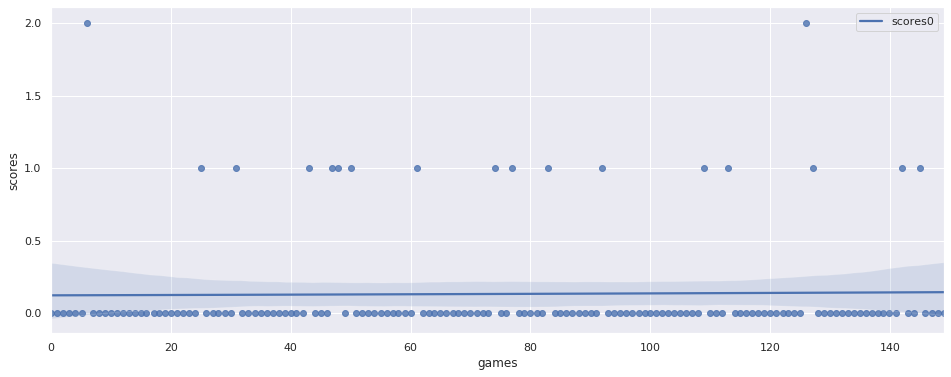

In [65]:
_, scores0, _ = playgame(150, mode='random');
plot_score(scores0=scores0)

## Let's play

In [66]:
agent1, scores1, movie1 = playgame(150);

# save results
np.array(scores1).dump('scores1')
movie1.save('best-play')

game: 150   highest: 25   mean:7.96    mean of last 10 games: 16.30


Comparing to the ramdon plays, our DQN agent is able to achieve a much higher score, bettern mean, and with a trend to improve performance as more games to play.

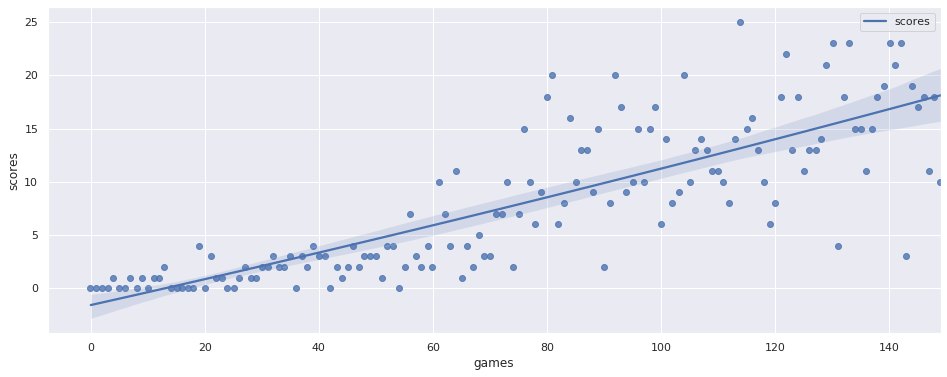

In [67]:
scores1 = np.load('scores1', allow_pickle=True)
plot_score(scores=scores1)

## What does the policy looks like

Here demonstrates a fragment of the policy that guides the game play.

In [78]:
states = ['000100010001','000001000010', '101010000001', '010010001000']
policy = []
for state in states:
    state = vectorize(state)
    row = [tran_state(state)]
    prediction = agent1.model.predict(state.reshape(1,-1))[0].round(2)
    highest = np.argmax(prediction)
    prediction = list(prediction)
    prediction[highest] = f'<b style="background-color:lightgreen">{prediction[highest]:.2f}</b>'
    row += list(map(str, prediction))
    policy.append(row)

headers = ['STATE \ ACTION', 'GO NORTH', 'GO EAST', 'GO SOUTH', 'GO WEST']
display(HTML(tabulate.tabulate(policy, tablefmt='html', headers=headers)))

STATE \ ACTION,GO NORTH,GO EAST,GO SOUTH,GO WEST
immediate danger at Wheading Wfood in W,0.05,0.81,0.1,0.04
no dangerheading Efood in S,0.07,0.16,0.73,0.04
immediate danger at N Sheading Nfood in W,0.02,0.90,0.03,0.05
immediate danger at Eheading Nfood in N,0.99,0.0,0.01,0


In [87]:
# Execute this cell to see the actual game play that achieved the highest score.
BestPerformanceMovie().load('best-play').play()

### How it learns to avoid danger

The following tracks how the agent learns from a fatal mistake, and how to avoid the same mistake in subsequent game plays.

game: 80   highest: 14   mean:2.15    mean of last 10 games: 7.20
immediate danger at E S, heading W, food in N E  ... decided to go S... Bang💥!!


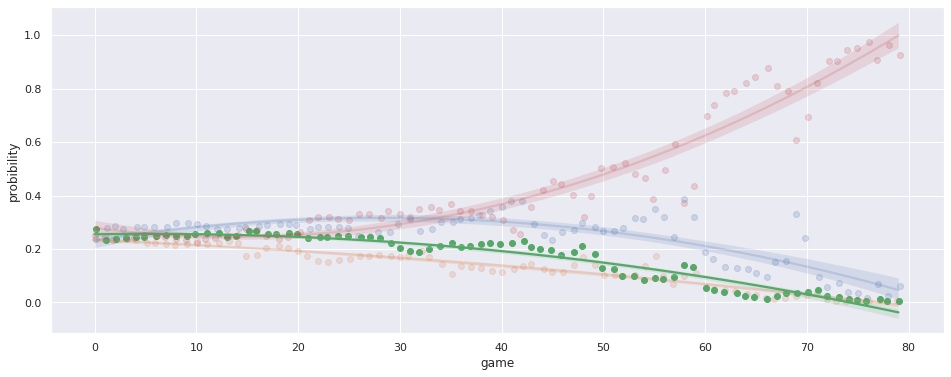

In [70]:
class CrashAvoidanceLogger:
    fatal_state = None
    fatal_act = None
    qvals = []

    def log(self, agent, state, action, qval):
        if self.fatal_state is None and qval is not None:
            self.fatal_state = state
            self.fatal_act = action
        self.qvals.append(agent.model.predict(self.fatal_state)[0])

    def plot(self):
        print(tran_state(self.fatal_state[0].tolist()).replace('<br/>', ', '), f' ... decided to go {BEARING[self.fatal_act]}... Bang💥!!')
        data = np.array(self.qvals)
        plt.figure(figsize=(16, 6))
        sns.set(color_codes=True)
        for action in range(4):
            alpha = 1 if action == self.fatal_act else .2
            g = sns.regplot(range(len(data)), data[:,action], x_jitter=.2, order=2, scatter_kws={'alpha':alpha}, line_kws={'alpha':alpha})
            g.set(xlabel='game', ylabel='probibility');
        plt.show()

logger = CrashAvoidanceLogger()
agent1, scores1, movie1 = playgame(80, logger=logger.log);
logger.plot()

### Dreaming

In the previous game plays, the agent only learns from the immediate consequence of each movement. We can create a long term memory, and after each game, we can have the agent replay some random memory fragments to reinforce the leanred policy.

In [71]:
def dream(self):
    batch_size = 1000
    if len(self.memory) > batch_size:
        minibatch = random.sample(self.memory, batch_size)
    else:
        minibatch = self.memory
    for obs, action, reward, new_obs, gameover in minibatch:
        self._train(obs, action, reward, new_obs, gameover)

In [72]:
agent, scores2, movie2 = playgame(150, logger=logger.log, dream=True);

# save results
np.array(scores2).dump('scores2')

previously (no dream)...highest: 14     mean: 2.15     mean of last 10 games: 7.2
game: 150   highest: 42   mean:9.23    mean of last 10 games: 22.80


no dream  ...highest: 25     mean: 7.96     mean of last 10 games: 16.3
with dream...highest: 42     mean: 9.23     mean of last 20 games: 19.6


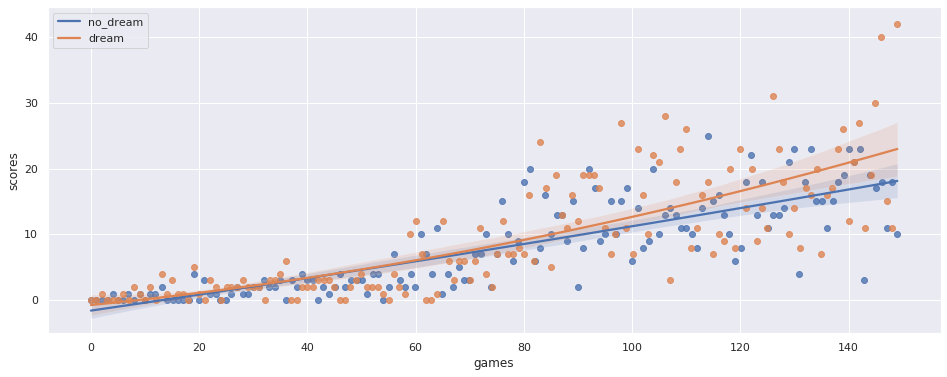

In [86]:
scores1 = np.load('scores1', allow_pickle=True)
print(f'no dreaming  ...highest: {int(scores1.max())}     mean: {scores1.mean().round(2)}     mean of last 10 games: {scores1[-10:].mean().round(2)}')
scores2 = np.load('scores2', allow_pickle=True)
print(f'with dreaming...highest: {int(scores2.max())}     mean: {scores2.mean().round(2)}     mean of last 20 games: {scores2[-20:].mean().round(2)}')
plot_score(no_dream=scores1, dream=scores2)

## Double-headed Python
![double-headed python](https://ichef.bbci.co.uk/images/ic/960x540/p06lyd7h.jpg)

- **The snake is driven by two independent neural nets**
- **They are each half blind, i.e. one head can sense danger only at north and east, while the other only south and west**
- **One can sense food at north and east, the other south and west**
- **Each can vote for any of the 4 directions**
- **In a dittion, each can also abstain; therefore the neural net output is a 5-vector**
- **If no one abstains, and both vote differently, then toss a coin to pick one to follow**

In [74]:
def split_observation(observation):
    ''' Each head has partial observation '''
    immediate_dangers, heading, food_orientation = np.array_split(observation[0], 3)
    danger1, danger2 = np.array_split(immediate_dangers, 2)
    food_ori1, food_ori2 = np.array_split(food_orientation, 2)
    observation1 = np.concatenate((danger1, heading, food_ori1)).reshape(1, -1)
    observation2 = np.concatenate((danger2, heading, food_ori2)).reshape(1, -1)
    return observation1, observation2

In [75]:
def double_heads(games, mode='training', load_weights=False, dream=False, boost_coop=False):
    env = gym.make('MaurockSnake-v0')
    observation = env.reset()
    input_dim = observation.shape[1] - 4
    # Setting mode to double_heads creates a network with output of 5
    agents = [DQNAgent(env.action_space, input_dim, mode='double_heads') for i in range(2)]
    scores = np.array([])
    movie = BestPerformanceMovie()
    # record cooperation index, 2 for agreement, 1 for any abstain, 0 for disagreement
    coop_idx = []
    for game_counter in range(games):
        observations = split_observation(env.reset())
        while True:
            # Each agent makes its own guess
            original_votes = np.array([agent.predict(obs, game_counter) for agent, obs in zip(agents, observations)])
            # Remove abstain votes, i.e. 4
            votes = original_votes[original_votes!=4]

            if len(votes) == 2:
                # Toss a coin votes still has two values, i.e. they disagree with each other
                actual_action = random.sample(votes.tolist(), 1)[0]
                
                # 2 for concensus, 0 for disagreement
                coop_idx.append(2 if votes[0] == votes[1] else 0)
            elif len(votes) == 1:
                actual_action = votes[0]
                
                # 1 for abstain
                coop_idx.append(1)
            else:
                # No one votes, take a guess
                actual_action = env.action_space.sample()
                # update votes array so that the training below reflects the change
                votes = [actual_action] * 2
                # concensus, so 2 for coop_idx
                coop_idx.append(2)

            new_obs, reward, gameover, info = env.step(actual_action)
            if boost_coop:
                reward += 0.5 * coop_idx[-1]
            new_observations = split_observation(new_obs)
            movie.record(env.get_image())

            for i, agent in enumerate(agents):
                my_vote = original_votes[i]
                my_old_obs = observations[i]
                my_new_obs = new_observations[i]
                agent.train(my_old_obs, my_vote, reward, my_new_obs, gameover)
            observations = new_observations

            if gameover:
                scores = np.append(scores, env.score)
                movie.cut(env.score)
                print(f'\rgame: {game_counter + 1}   highest: {int(scores.max())}   mean:{scores.mean():.2f}', end='', flush=True)
                if dream:
                    [agent.dream() for agent in agents]
                break
            observation = new_obs

    if not load_weights:
        agent.save_model()
    print()
    return scores, movie, coop_idx

### How cooperative are the two heads

game: 150   highest: 10   mean:1.87


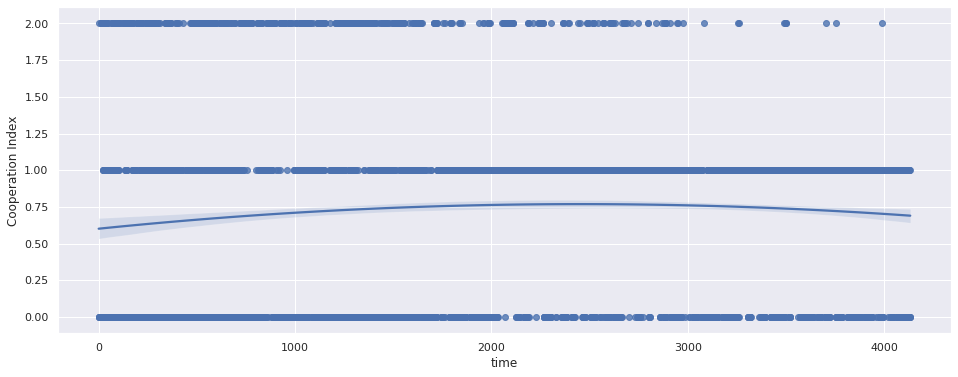

coop index mean: 0.7252056119980649


In [76]:
def plot_coop(data):
    plt.figure(figsize=(16, 6))
    sns.set(color_codes=True)
    g = sns.regplot(range(len(data)), data, x_jitter=.2, order=2)
    g.set(xlabel='time', ylabel='Cooperation Index');
    plt.show()
    print('coop index mean:', np.array(data).mean())

scores, movie2, coop_idx = double_heads(150, dream=False)
plot_coop(coop_idx)

The above plot shows the two agents disagree with each other more than agreeing. Let's see what happens if we boost the reward for agreeing with each other.

### Boost cooperation

game: 150   highest: 1   mean:0.05


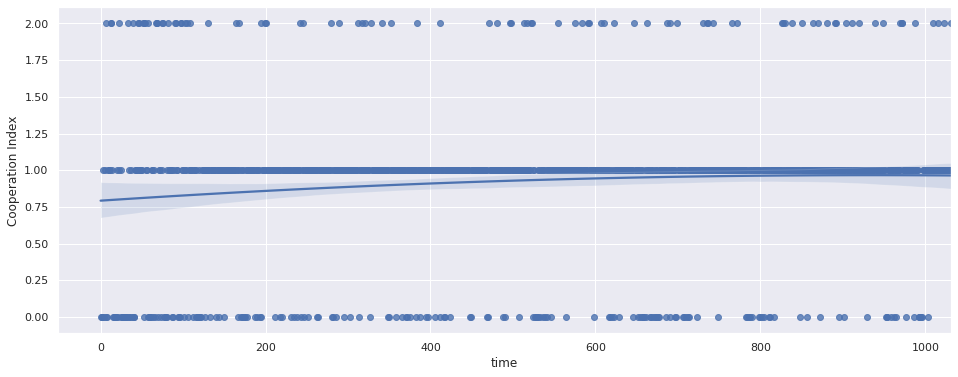

coop index mean: 0.9137596899224806


In [77]:
# play the game with boost_coop=True
scores, movie2, coop_idx = double_heads(150, dream=False, boost_coop=True)
plot_coop(coop_idx)

The result is surprising! The cooperative index did go up, but the game play is abysmal. After some pondering, I realize the reward boosting is not reflected in the oberservation, i.e. the agent can get different rewards from the same state, without knowing why. It may improve the performance if the observation include the parter's action.

# Lessons Learned

- During the code migration to the OpenAI Gym environment, I introduced several bugs into the system. But neural net is such a resilient black box, its performance was still decent, achieving observable learning ability. I was only able to discover those bugs by measuring target behavior of expected results. So it's very important to set up measurable expectations and track the performance accordingly.
- Multi-agent RL is tough!